![alt text](FGV_logo.png)

# Deep Learning

Vamos utilizar o script referente ao livro online: [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap1.html)<br>
com algumas modificações


In [1]:
#### Libraries
# Standard library
import random

# Third-party libraries
import numpy as np
import pandas as pd

In [2]:
#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [3]:
# graficos
import seaborn as sns
%matplotlib inline
sns.set_context('paper')

In [4]:
# interatividade
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider
import ipywidgets as widgets

# caso necessario instalar ipywidgets 
# com pip...
# pip install ipywidgets
# jupyter nbextension enable --py --sys-prefix widgetsnbextension (necessario se virtualenv)
# com conda...
# conda install -c conda-forge ipywidgets

#### importando e explorando mnist

In [5]:
import mnist_loader
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

train = list(training_data)
valid = list(validation_data)
teste = list(test_data)

In [6]:
# quantas amostras existem em cada dataset?
print(len(train))
print(len(valid))
print(len(teste))

50000
10000
10000


In [7]:
# qual o shape de uma amostra?
# qual o label de uma amostra?
print (train[20][0].shape)
print (train[20][1])

(784, 1)
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


In [8]:
print (teste[20][0].shape)
print (teste[20][1])

(784, 1)
9


In [9]:
valid[21][1]

7

amostra = 34517
label = 9


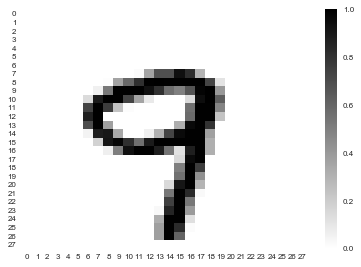

In [10]:
# checando algumas amostras
def f(x, dataset):
    if dataset == 'treino':
        d = train
    elif dataset == 'teste':
        d = teste
    elif dataset == 'validacao':
        d = valid
    if x is '': 
        sns.heatmap(np.zeros((28,28)), cmap = 'gray_r', vmin = 0, vmax = 1)
    else:
        amostra = int(x)
        print('amostra =', x)
        print('label =', d[amostra][1].reshape(10,).argmax() if dataset == 'treino' else d[amostra][1])
        sns.heatmap(d[amostra][0].reshape(28,28), cmap = 'gray_r', vmin = 0, vmax = 1)

interact(f, dataset = ['treino', 'validacao', 'teste'], 
         x = IntSlider(min = 0, max = len(train) - 1, step = 1, continuous_update = False), );

#### network.py

In [11]:
# %load network.py

"""
network.py
~~~~~~~~~~
IT WORKS

A module to implement the stochastic gradient descent learning
algorithm for a feedforward neural network.  Gradients are calculated
using backpropagation.  Note that I have focused on making the code
simple, easily readable, and easily modifiable.  It is not optimized,
and omits many desirable features.
"""


class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""

        training_data = list(training_data)
        n = len(training_data)

        if test_data:
            test_data = list(test_data)
            n_test = len(test_data)

        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print("Epoch {} : {} / {}".format(j,self.evaluate(test_data),n_test));
            else:
                print("Epoch {} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

#### treinando o modelo

In [12]:
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

In [13]:
net = Network([784, 30, 10])

In [14]:
net.SGD(training_data, 15, 10, 3.0, test_data=test_data)

Epoch 0 : 9048 / 10000
Epoch 1 : 9232 / 10000
Epoch 2 : 9238 / 10000
Epoch 3 : 9329 / 10000
Epoch 4 : 9345 / 10000
Epoch 5 : 9366 / 10000
Epoch 6 : 9369 / 10000
Epoch 7 : 9390 / 10000
Epoch 8 : 9400 / 10000
Epoch 9 : 9410 / 10000
Epoch 10 : 9437 / 10000
Epoch 11 : 9466 / 10000
Epoch 12 : 9427 / 10000
Epoch 13 : 9450 / 10000
Epoch 14 : 9467 / 10000
Epoch 15 : 9464 / 10000
Epoch 16 : 9466 / 10000
Epoch 17 : 9484 / 10000
Epoch 18 : 9481 / 10000
Epoch 19 : 9494 / 10000
Epoch 20 : 9448 / 10000
Epoch 21 : 9474 / 10000
Epoch 22 : 9488 / 10000
Epoch 23 : 9452 / 10000
Epoch 24 : 9503 / 10000
Epoch 25 : 9502 / 10000
Epoch 26 : 9489 / 10000
Epoch 27 : 9492 / 10000
Epoch 28 : 9508 / 10000
Epoch 29 : 9496 / 10000


#### testando o modelo

In [15]:
def softmax(a):
    return np.exp(a) / np.exp(a).sum()

In [16]:
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

train = list(training_data)
valid = list(validation_data)
teste = list(test_data)

amostra = 313
label = 3


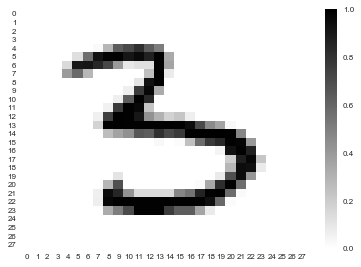

In [17]:
interact(f, dataset = ['treino', 'validacao', 'teste'], 
         x = IntSlider(min = 0, max = len(train) - 1, step = 1, continuous_update = False), );

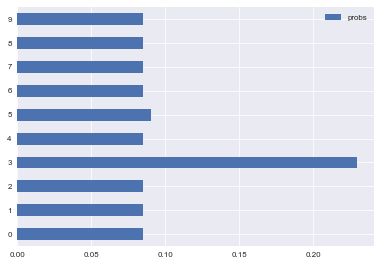

In [18]:
amostra = 313
imagem = teste[amostra][0]
preds = net.feedforward(imagem)
probs = softmax(preds)

pd.DataFrame(probs, columns = ['probs']).plot(kind = 'barh')

In [19]:
preds

array([[  5.24153396e-09],
       [  6.03946320e-06],
       [  4.83404565e-07],
       [  9.95959642e-01],
       [  3.47383898e-04],
       [  6.19349955e-02],
       [  2.72348070e-06],
       [  1.45417385e-10],
       [  5.08480130e-08],
       [  1.37018987e-13]])